# BUSI/COMP 488-003 Assignment 2

## Coffee Shop Strategy

Group 5: Avi Agrawal, Reed Dickerson, Izzy Parrett, Shivram Ramkumar, Nora Xia, Natalie Yuziuk

## Question
* What specific changes can increase the coffee shop's profit/profitability?

## Scenario
A local North Carolina coffee shop that is located in a suburban strip mall is struggling with (a) retaining customers, (b) increasing daily transactions, and (c) managing its rather large assortment. There aren’t a lot of thriving businesses in the strip mall and the roads close are not that heavily frequented. There is a YMCA right around the corner - but it is unclear how to attract its members to come over for coffee or sweets. There are also several small professional offices in the adjacent area such as a dentist and an animal clinic.

#### Open in Google Colab

## Data cleaning

This section relies on cleaning the data columns and standardization of price point names, sizes, and spellings. It is recommended to the business to have a standardized set of inventory to increase the ease and efficiency of future data analysis.

In [1]:
# data is in pickle5 format
!pip3 install pickle5

     |████████████████████████████████| 256 kB 3.8 MB/s 


In [2]:
# make necessary imports
import pandas as pd
import pickle5 as pickle
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from matplotlib.pyplot import figure
import random
from matplotlib import rcParams

In [3]:
# mount your google drive to access data IF WORKING in COLAB
from google.colab import drive
drive.mount('/content/drive')
# !ls /content/drive/MyDrive/BUSI488/Assignment2/

Mounted at /content/drive


In [4]:
# use your own file path to load in pkl file
file_path = '/content/drive' + \
            '/MyDrive/BUSI488/Assignment2/488-2022-Assignment2-Coffee_CashierLog-2018-2020.pkl' # enter file path here, with the provided log file unaltered
with open(file_path, "rb") as fh:
  df = pickle.load(fh)
df.head()

,TimeStamp,BasketID,Category,Item,Qty,Price Point Name,SKU,Modifiers Applied,Gross Sales,Discounts,Notes,Unit,Count,Event Type,PaymentID,CustomerID
0,10/5/18 13:09:39,57034,From the Barista,Vanilla Chai Latte,1,12oz,NaN,NaN,$3.50,$0.00,NaN,ea,1,Payment,42740,5477
1,10/5/18 13:09:39,57034,From the Barista,Flavored Latte,1,20oz,NaN,NaN,$4.45,($0.44),NaN,ea,1,Payment,42740,5477
2,10/5/18 13:15:00,52838,What's Brewing,Coffee of the Day,1,16oz,NaN,NaN,$2.25,$0.00,NaN,ea,1,Payment,50902,-1
3,10/5/18 13:20:11,17649,From the Barista,Latte,1,20oz,NaN,NaN,$3.95,$0.00,NaN,ea,1,Payment,45994,-1
4,10/5/18 13:41:41,2511,None,Custom Amount,1,NaN,NaN,NaN,$0.47,$0.00,NaN,ea,1,Payment,9852,-1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91880 entries, 0 to 91879
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   TimeStamp          91880 non-null  object
 1   BasketID           91880 non-null  int64 
 2   Category           91880 non-null  object
 3   Item               91880 non-null  object
 4   Qty                91880 non-null  int64 
 5   Price Point Name   91544 non-null  object
 6   SKU                6021 non-null   object
 7   Modifiers Applied  11805 non-null  object
 8   Gross Sales        91880 non-null  object
 9   Discounts          91880 non-null  object
 10  Notes              2227 non-null   object
 11  Unit               91880 non-null  object
 12  Count              91880 non-null  int64 
 13  Event Type         91880 non-null  object
 14  PaymentID          91880 non-null  int64 
 15  CustomerID         91880 non-null  int64 
dtypes: int64(5), object(11)
memory usage: 11

In [6]:
# convert Timestamp to a datetime type so that we can perform time based analysis.
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])
# gross Sales and Discounts have special characters stopping pandas from recognizing them as floats
# we first remove these then cast to type float
df[['Gross Sales','Discounts']] = df[['Gross Sales','Discounts']].replace({'[\$,\)]':'','\(':'-'}, regex=True).astype('float')
df['UnitPrice'] = np.round(df['Gross Sales'] / df['Qty'],2)
# now inspect to make sure datatypes are fixed.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91880 entries, 0 to 91879
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   TimeStamp          91880 non-null  datetime64[ns]
 1   BasketID           91880 non-null  int64         
 2   Category           91880 non-null  object        
 3   Item               91880 non-null  object        
 4   Qty                91880 non-null  int64         
 5   Price Point Name   91544 non-null  object        
 6   SKU                6021 non-null   object        
 7   Modifiers Applied  11805 non-null  object        
 8   Gross Sales        91880 non-null  float64       
 9   Discounts          91880 non-null  float64       
 10  Notes              2227 non-null   object        
 11  Unit               91880 non-null  object        
 12  Count              91880 non-null  int64         
 13  Event Type         91880 non-null  object        
 14  Paymen

In [7]:
# identify useless or redundant columns
df[['Unit', 'Event Type', 'Count','Qty']].value_counts(sort=False)

Unit  Event Type  Count  Qty
ea    Payment      1      1     86558
                   2      2      4830
                   3      3       294
                   4      4        64
                   5      5        17
                   6      6         2
                   7      7         1
                   8      8         1
                   9      9         1
                   10     10        2
                   12     12        2
                   20     20        1
                   30     30        1
      Refund      -3     -3         2
                  -2     -2         5
                  -1     -1        99
dtype: int64

In [8]:
# the notes will not be analyzed, and unit is a useless column
df = df.drop(['Notes', 'Unit'], axis=1)
print(df.head())

            TimeStamp  BasketID          Category                Item  Qty  \
0 2018-10-05 13:09:39     57034  From the Barista  Vanilla Chai Latte    1   
1 2018-10-05 13:09:39     57034  From the Barista      Flavored Latte    1   
2 2018-10-05 13:15:00     52838    What's Brewing   Coffee of the Day    1   
3 2018-10-05 13:20:11     17649  From the Barista               Latte    1   
4 2018-10-05 13:41:41      2511              None       Custom Amount    1   

  Price Point Name  SKU Modifiers Applied  Gross Sales  Discounts  Count  \
0             12oz  NaN               NaN         3.50       0.00      1   
1             20oz  NaN               NaN         4.45      -0.44      1   
2             16oz  NaN               NaN         2.25       0.00      1   
3             20oz  NaN               NaN         3.95       0.00      1   
4              NaN  NaN               NaN         0.47       0.00      1   

  Event Type  PaymentID  CustomerID  UnitPrice  
0    Payment      42740  

In [9]:
# quantity and count are the same
print(df[df['Qty'] != df['Count']])

Empty DataFrame
Columns: [TimeStamp, BasketID, Category, Item, Qty, Price Point Name, SKU, Modifiers Applied, Gross Sales, Discounts, Count, Event Type, PaymentID, CustomerID, UnitPrice]
Index: []


In [10]:
# drop quantity
df = df.drop(['Qty'], axis=1)
print(df.head())

            TimeStamp  BasketID          Category                Item  \
0 2018-10-05 13:09:39     57034  From the Barista  Vanilla Chai Latte   
1 2018-10-05 13:09:39     57034  From the Barista      Flavored Latte   
2 2018-10-05 13:15:00     52838    What's Brewing   Coffee of the Day   
3 2018-10-05 13:20:11     17649  From the Barista               Latte   
4 2018-10-05 13:41:41      2511              None       Custom Amount   

  Price Point Name  SKU Modifiers Applied  Gross Sales  Discounts  Count  \
0             12oz  NaN               NaN         3.50       0.00      1   
1             20oz  NaN               NaN         4.45      -0.44      1   
2             16oz  NaN               NaN         2.25       0.00      1   
3             20oz  NaN               NaN         3.95       0.00      1   
4              NaN  NaN               NaN         0.47       0.00      1   

  Event Type  PaymentID  CustomerID  UnitPrice  
0    Payment      42740        5477       3.50  
1    P

In [11]:
mods = df["Modifiers Applied"].dropna() # mods in series
dfmod = mods.str.split(', ', expand=True) # split into data frame
dfmod = pd.melt(dfmod).dropna().drop(columns =['variable']) # melt into single list.
dfmod.value_counts().sort_index() # check for funky values

value                    
1 pump Flavor                   3
12oz                           10
16oz                            1
2%                            138
Add Extra Espresso Shot      2541
Add Extra Flavor             2570
Add Extra Whipped Cream        56
Add one pump                  856
Almond                        529
Caramel                        65
Chai Sweeten                  131
Coconut                        98
Dark Chocolate                 37
Extra Shot                      2
Leafy Green)                   22
Milk Substitution            4282
Oat                           288
Smoothie Add-ins (Protien      22
Soy                           139
White Chocolate                12
skim                          196
whole                         572
dtype: int64

In [12]:
df["Modifiers Applied"] = df["Modifiers Applied"].replace({
        '1 pump Flavor':'Add one pump',
         '\(Protien\, Leafy Green\)':'',
         'Extra Shot':'Add Extra Espresso Shot',
         }, regex=True).str.strip()

In [13]:
# clean the price points
df["Price Point Name"] = df["Price Point Name"].str.lower().replace({
    ' ':''}, regex=True).replace({
        '160z':'16oz','12oz.':'12oz','3.00oz':'3oz','.05lb':'0.5lb',
         'regularprice':'regular','twoshot':'doubleshot','quad':'quadshot',
         'price1':'regular', 'individual':'regular', 'rectangular':'regular', 'chobani':'regular',
         'kidssize':'10oz', 'medium':'16oz', 'large':'20oz', # Sizing from SKU
         '2x12ozcoffeedrinksor1x20ozcoffeedrinkwithpastry':'regular'}) # already in Promotion category

In [14]:
# look at the distribution of price points
df["Price Point Name"].value_counts().sort_index()

0.5lb           206
10oz            543
12oz          16233
16oz          31979
1lb            1026
20oz          22404
3oz              30
3pack            67
8oz             768
curved            7
doubleshot      972
quadshot        288
regular       16925
tripleshot       96
Name: Price Point Name, dtype: int64

In [15]:
# clean item strings
df.Item = df.Item.str.strip().replace(
    {' & ':' ',
     'Barry':'Berry',
     'CrÃ©me':'Cream',
     'Sargento ':'',
     'OhYeah( Bar)?':'ONE Bar ||', # OhYeah rebranded https://one1brands.com/about-us/
     'Herbert':'Hubert',
     'Chocolat ':'Chocolate ',
     'Maripan':'Marzipan',
     'Pumpkin Pie':'Pumpkin Spice',
     'Rich Strawberry':'Very Strawberry',
     'S.F':'Sugar Free',
     'Gluten-Free':'Vegan'}, regex=True)
df.Item = df.Item.str.strip().replace(
    {'Fair Life Chocolate':'Fairlife Rich Chocolate Milk',
     'Belvita Blueberry':'Belvita',
     'Lolo':'LoLo 12oz Latte Pastry',
     'Nutella And Bread sticks':'Nutella And Breadsticks',
     'Walkers Shortbread':'Shortbread Walker',
     'Walkers Round Shortbread':'Shortbread Walker'})

In [16]:
# clean categories
unitdf = df[['UnitPrice','Item','Category','Price Point Name','Modifiers Applied']].fillna('regular') # data frame of units and categories
unitdf[unitdf["Modifiers Applied"].str.contains("oz")].value_counts()

df.Category = df.Category.replace(
    {'LoLo':'Promotion',
     'Promotion Account':'Promotion'}, regex=True)
unitdf[unitdf['Category'].isin(['Promotion'])].value_counts()

UnitPrice  Item                     Category   Price Point Name  Modifiers Applied
0.0        Eastwood (small Coffee)  Promotion  regular           regular              4
dtype: int64

In [17]:
# recode some incorrect categories
df.loc[df.Item.str.startswith('Fairlife'), 'Category'] = 'Display Fridge'
df.loc[df.Item.str.startswith('Cold Brew'), 'Category'] = 'Cool Drink'
df.loc[df.Item.str.startswith('Classic Iced Coffee') | 
       (df.Item == 'Gingerbread Latte') |
       (df.Item == 'Almond White Mocha'), 'Category'] = 'From the Barista'
df.loc[df.Item.str.startswith('Kind Crunchy') |
       df.Item.str.startswith('Vega Bar') |
       df.Item.str.startswith('Nonni'), 'Category']= 'Counter Top'
df.loc[df.Item == "Honduras", 'Category'] = 'Coffee Bean Single Origin'
df.loc[df.Item == "Pumpkin Spice Decaf Coffee Bean", 'Category'] = 'Coffee Bean Decaf'
df.loc[df.Item.str.contains('Gum'),['Category','Item']] = ['Counter Top','Gum']
df.loc[df.Item.str.contains('Pecan') & (df['UnitPrice'] == 2.25),['Category','Item']] = ['Wheeler Seasonal','Pecans']

In [18]:
# impute items with None and another code
dfNotNone = df[['Category','Item']][df.Category != 'None'].drop_duplicates().set_index('Item') 
mask = (df.Category == 'None') & (df.Item.isin(dfNotNone.index)) # rows to fix
df.loc[mask, 'Category'] = dfNotNone.Category.loc[df.Item[mask]].values # values to fix them with

In [19]:
df['Event Type'].value_counts()

Payment    91774
Refund       106
Name: Event Type, dtype: int64

In [20]:
# drop refunds, focus on purchases
df = df[df['Event Type'] != 'Refund']
df['Event Type'].value_counts()

Payment    91774
Name: Event Type, dtype: int64

In [21]:
# drop event type column
df = df.drop(['Event Type'], axis=1)
print(df.head())

            TimeStamp  BasketID          Category                Item  \
0 2018-10-05 13:09:39     57034  From the Barista  Vanilla Chai Latte   
1 2018-10-05 13:09:39     57034  From the Barista      Flavored Latte   
2 2018-10-05 13:15:00     52838    What's Brewing   Coffee of the Day   
3 2018-10-05 13:20:11     17649  From the Barista               Latte   
4 2018-10-05 13:41:41      2511              None       Custom Amount   

  Price Point Name  SKU Modifiers Applied  Gross Sales  Discounts  Count  \
0             12oz  NaN               NaN         3.50       0.00      1   
1             20oz  NaN               NaN         4.45      -0.44      1   
2             16oz  NaN               NaN         2.25       0.00      1   
3             20oz  NaN               NaN         3.95       0.00      1   
4              NaN  NaN               NaN         0.47       0.00      1   

   PaymentID  CustomerID  UnitPrice  
0      42740        5477       3.50  
1      42740        5477    

In [22]:
# convert categorical columns from text to category
catcols = ['Price Point Name','Modifiers Applied', 'Category', 'Item']
mem_before = df[catcols].memory_usage(deep=True).rename('before')
df[catcols] = df[catcols].astype('category')
mem_after = df[catcols].memory_usage(deep=True).rename('after')
mem = pd.concat([mem_before, mem_after, 
                 np.round(100*mem_after/mem_before,3).rename('percent')], axis=1)
mem

,before,after,percent
Index,734192,734192,100.000
Price Point Name,5645217,93204,1.651
Modifiers Applied,3428866,101104,2.949
Category,6538697,93813,1.435
Item,6663773,210890,3.165


In [23]:
print(df.head())

            TimeStamp  BasketID          Category                Item  \
0 2018-10-05 13:09:39     57034  From the Barista  Vanilla Chai Latte   
1 2018-10-05 13:09:39     57034  From the Barista      Flavored Latte   
2 2018-10-05 13:15:00     52838    What's Brewing   Coffee of the Day   
3 2018-10-05 13:20:11     17649  From the Barista               Latte   
4 2018-10-05 13:41:41      2511              None       Custom Amount   

  Price Point Name  SKU Modifiers Applied  Gross Sales  Discounts  Count  \
0             12oz  NaN               NaN         3.50       0.00      1   
1             20oz  NaN               NaN         4.45      -0.44      1   
2             16oz  NaN               NaN         2.25       0.00      1   
3             20oz  NaN               NaN         3.95       0.00      1   
4              NaN  NaN               NaN         0.47       0.00      1   

   PaymentID  CustomerID  UnitPrice  
0      42740        5477       3.50  
1      42740        5477    

In [24]:
# which items get the most revenue?
# pd.set_option('max_rows', 300)
df.groupby(['Item'])['Gross Sales'].sum().sort_values(ascending=False)

Item
Coffee of the Day            45895.25
Coffee Chiller               24484.95
Flavored Latte               22133.05
Latte                        14509.85
Cold Brew                    14016.80
                               ...   
Coconut Cream                    3.50
ONE Bar || Salted Caramel        2.75
Walkers Choc Chip                2.60
Eastwood (small Coffee)          0.60
Daylight Coffee                  0.00
Name: Gross Sales, Length: 248, dtype: float64

In [25]:
figure(figsize=(8, 6), dpi=130)
plt.pie(labels=df['Item'], x=df['Gross Sales']);

Error in callback <function flush_figures at 0x7f12f1ad03b0> (for post_execute):


KeyboardInterrupt: ignored

In [26]:
# here we extract more useful comlumns from our Datetime one
df['Date'] = df.TimeStamp.dt.date
df['Weekday'] = df.TimeStamp.dt.day_name()
df['Year'] = df.TimeStamp.dt.year
df['Month'] = df.TimeStamp.dt.month
df['Month-Year'] = df.TimeStamp.dt.month_name() + "-" + df.TimeStamp.dt.year.astype(str)
df['Hour'] = df.TimeStamp.dt.hour

#verify to ensure that it worked correctly
df.head()

,TimeStamp,BasketID,Category,Item,Price Point Name,SKU,Modifiers Applied,Gross Sales,Discounts,Count,PaymentID,CustomerID,UnitPrice,Date,Weekday,Year,Month,Month-Year,Hour
0,2018-10-05 13:09:39,57034,From the Barista,Vanilla Chai Latte,12oz,NaN,NaN,3.50,0.00,1,42740,5477,3.50,2018-10-05,Friday,2018,10,October-2018,13
1,2018-10-05 13:09:39,57034,From the Barista,Flavored Latte,20oz,NaN,NaN,4.45,-0.44,1,42740,5477,4.45,2018-10-05,Friday,2018,10,October-2018,13
2,2018-10-05 13:15:00,52838,What's Brewing,Coffee of the Day,16oz,NaN,NaN,2.25,0.00,1,50902,-1,2.25,2018-10-05,Friday,2018,10,October-2018,13
3,2018-10-05 13:20:11,17649,From the Barista,Latte,20oz,NaN,NaN,3.95,0.00,1,45994,-1,3.95,2018-10-05,Friday,2018,10,October-2018,13
4,2018-10-05 13:41:41,2511,None,Custom Amount,NaN,NaN,NaN,0.47,0.00,1,9852,-1,0.47,2018-10-05,Friday,2018,10,October-2018,13


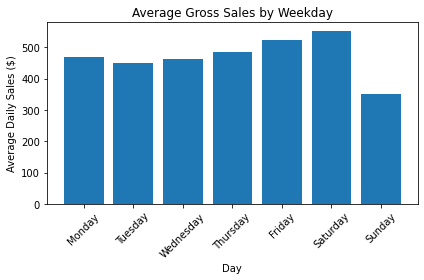

In [27]:
#First find total sales for each day
temp = df.groupby(['Date', 'Weekday'], as_index = False).agg({'Gross Sales' : 'sum'})
#Now Find average sales for each weekday
trans_by_weekday = temp.groupby('Weekday').agg({'Gross Sales' : 'mean'}).reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
#Plot the findings on a bar chart
plt.bar(trans_by_weekday.index, trans_by_weekday['Gross Sales'])
plt.xlabel('Day')
plt.xticks(rotation = 45)
plt.ylabel('Average Daily Sales ($)')
plt.title('Average Gross Sales by Weekday')
plt.tight_layout()
plt.show()

## The Coffee Shop during Covid - Gross sales
Here we check how the distributions change after Covid. Since they are fundamentally similar with the respect to demand for products, and since we are currently in the midst of an increase in sales (getting closer to pre-pandemic levels), we use holistic averages.

In [28]:
# start a covid dataframe, starting from March, the month in which Covid lockdowns began
covid = df[df['Date'] > pd.Timestamp(2020,3,1)]

/usr/local/lib/python3.7/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [29]:
# visualize a covid dataframe
covid

,TimeStamp,BasketID,Category,Item,Price Point Name,SKU,Modifiers Applied,Gross Sales,Discounts,Count,PaymentID,CustomerID,UnitPrice,Date,Weekday,Year,Month,Month-Year,Hour
74483,2020-03-02 12:45:49,46852,Display Fridge,Water Dasani,regular,49000027624,NaN,1.10,-0.61,1,43958,8888,1.10,2020-03-02,Monday,2020,3,March-2020,12
74484,2020-03-02 12:19:17,62913,From the Barista,Iced Latte,16oz,NaN,Milk Substitution,4.10,0.00,1,28436,3887,4.10,2020-03-02,Monday,2020,3,March-2020,12
74485,2020-03-02 12:27:24,26812,What's Brewing,Coffee of the Day,12oz,NaN,NaN,1.85,0.00,1,552,3554,1.85,2020-03-02,Monday,2020,3,March-2020,12
74486,2020-03-02 12:29:25,38321,From the Barista,Hazelnut Bliss,16oz,NaN,Milk Substitution,4.75,0.00,1,18289,7087,4.75,2020-03-02,Monday,2020,3,March-2020,12
74487,2020-03-02 12:35:19,53098,From the Barista,Flavored Latte,20oz,NaN,NaN,4.45,0.00,1,30874,1197,4.45,2020-03-02,Monday,2020,3,March-2020,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91875,2020-10-05 10:00:35,59507,Cool Drink,Cold Brew,20oz,NaN,NaN,7.10,-0.57,2,54624,7112,3.55,2020-10-05,Monday,2020,10,October-2020,10
91876,2020-10-05 10:04:24,16245,From the Barista,Flavored Latte,20oz,NaN,"Add Extra Espresso Shot, whole",5.35,-0.92,1,49736,9676,5.35,2020-10-05,Monday,2020,10,October-2020,10
91877,2020-10-05 10:04:24,16245,From the Barista,Hazelnut Bliss,20oz,NaN,NaN,4.90,-0.84,1,49736,9676,4.90,2020-10-05,Monday,2020,10,October-2020,10
91878,2020-10-05 09:52:10,58753,From the Barista,Vanilla Chai Latte,16oz,NaN,whole,4.30,-0.35,1,60898,699,4.30,2020-10-05,Monday,2020,10,October-2020,9


In [30]:
# create a dataframe with gross sales ordered from greatest to least
order = covid.groupby(['Item'])['Gross Sales'].sum().sort_values(ascending=False)
order = pd.DataFrame(order)
order = order.reset_index()
order

,Item,Gross Sales
0,Coffee of the Day,8413.70
1,Coffee Chiller,7133.00
2,Cold Brew,3996.55
3,Flavored Latte,3690.30
4,Iced Flavored Latte,2691.90
...,...,...
243,Greek Yogurt Black Cherry,0.00
244,Greek Yogurt Blueberry,0.00
245,Greek Yogurt Raspberry,0.00
246,Greek Yogurt Strawberry,0.00


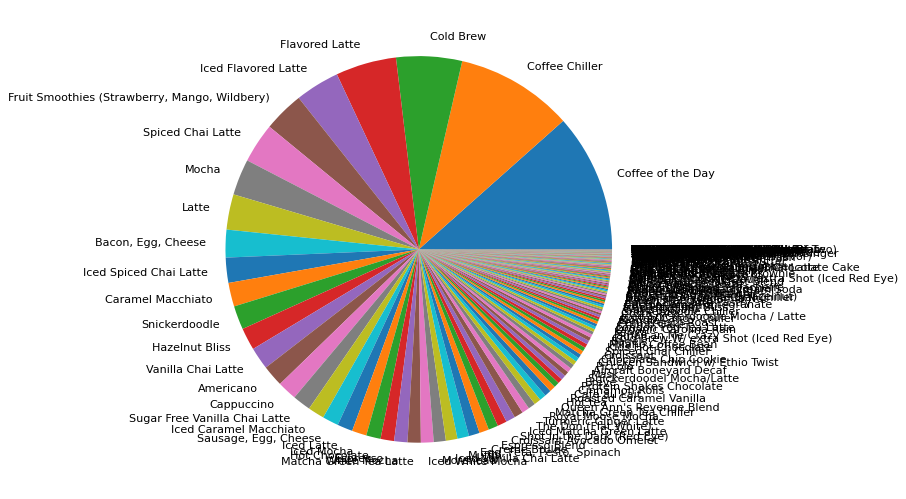

In [31]:
figure(figsize=(8, 8), dpi=80);
plt.pie(labels=order['Item'], x=order['Gross Sales']);

## Examine findings
The next section looks at different findings, looking to identify patterns or trends with which different recommendations can be made.

In [32]:
df

,TimeStamp,BasketID,Category,Item,Price Point Name,SKU,Modifiers Applied,Gross Sales,Discounts,Count,PaymentID,CustomerID,UnitPrice,Date,Weekday,Year,Month,Month-Year,Hour
0,2018-10-05 13:09:39,57034,From the Barista,Vanilla Chai Latte,12oz,NaN,NaN,3.50,0.00,1,42740,5477,3.50,2018-10-05,Friday,2018,10,October-2018,13
1,2018-10-05 13:09:39,57034,From the Barista,Flavored Latte,20oz,NaN,NaN,4.45,-0.44,1,42740,5477,4.45,2018-10-05,Friday,2018,10,October-2018,13
2,2018-10-05 13:15:00,52838,What's Brewing,Coffee of the Day,16oz,NaN,NaN,2.25,0.00,1,50902,-1,2.25,2018-10-05,Friday,2018,10,October-2018,13
3,2018-10-05 13:20:11,17649,From the Barista,Latte,20oz,NaN,NaN,3.95,0.00,1,45994,-1,3.95,2018-10-05,Friday,2018,10,October-2018,13
4,2018-10-05 13:41:41,2511,None,Custom Amount,NaN,NaN,NaN,0.47,0.00,1,9852,-1,0.47,2018-10-05,Friday,2018,10,October-2018,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91875,2020-10-05 10:00:35,59507,Cool Drink,Cold Brew,20oz,NaN,NaN,7.10,-0.57,2,54624,7112,3.55,2020-10-05,Monday,2020,10,October-2020,10
91876,2020-10-05 10:04:24,16245,From the Barista,Flavored Latte,20oz,NaN,"Add Extra Espresso Shot, whole",5.35,-0.92,1,49736,9676,5.35,2020-10-05,Monday,2020,10,October-2020,10
91877,2020-10-05 10:04:24,16245,From the Barista,Hazelnut Bliss,20oz,NaN,NaN,4.90,-0.84,1,49736,9676,4.90,2020-10-05,Monday,2020,10,October-2020,10
91878,2020-10-05 09:52:10,58753,From the Barista,Vanilla Chai Latte,16oz,NaN,whole,4.30,-0.35,1,60898,699,4.30,2020-10-05,Monday,2020,10,October-2020,9


In [33]:
# Define a function Render heatmap of total profit for each weekday-hour segment
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
 
    if not ax:
        ax = plt.gca()
 
    # Plot the heatmap
    im = ax.imshow(data, **kwargs)
 
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
 
    # Show all ticks
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # Label ticks with the respective list entries
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
 
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
 
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
 
    return im, cbar
 

In [34]:
#Create a 2D array of total profit for each weekday-hour combination
heatmap_df = df.groupby(['Weekday','Hour'])['Gross Sales'].agg('sum').unstack().fillna(0).reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
#Dropping hours with very low sales (typically closed)
heatmap_df.drop(columns = [19], inplace=True)
heatmap_array = np.array(heatmap_df)
 
# Create an array for the hours of operation and for the weekdays to be used as labels for the heatmap
hours = ["6-7am", "7-8am", "8-9am", "9-10am", "10-11am", "11am-12pm", "12-1pm", "1-2pm", "2-3pm", "3-4pm", "4-5pm", "6-7pm","7-8pm"]
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [35]:
heatmap_df

Hour,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20
Weekday,,,,,,,,,,,,,,,
Monday,0.0,1297.49,3506.31,6477.23,6610.48,5788.94,4179.26,3383.69,3314.84,3587.77,4058.98,3527.24,2161.96,1141.79,0.00
Tuesday,0.0,1430.80,3878.62,6786.39,6960.31,5241.91,3860.39,3451.68,3243.84,3105.58,3094.80,2646.81,1276.37,1043.68,14.00
Wednesday,5.0,1331.87,4476.21,7151.95,7857.49,5374.94,3874.04,3294.78,3135.15,3151.14,3074.52,2463.68,1230.93,1245.08,0.00
Thursday,0.0,2085.70,4156.72,6497.94,6524.82,5191.17,4074.04,3126.36,3265.90,3431.38,4776.48,3358.55,2004.20,1333.72,6.49
Friday,0.0,1645.50,4980.13,8233.85,8482.75,6048.06,4416.74,3819.80,3806.22,4095.46,3475.38,2766.56,1613.81,941.71,0.00
Saturday,0.0,0.00,617.10,7093.70,8868.24,10007.13,8176.10,5389.51,4683.10,4248.61,3667.21,2605.43,1332.20,688.50,3.00
Sunday,0.0,0.00,0.00,444.87,5998.42,5917.05,5212.94,3763.15,4925.21,3824.75,392.99,93.85,16.95,0.00,0.00


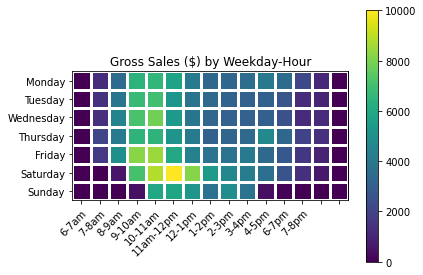

In [36]:
fig, ax = plt.subplots()
im, cbar = heatmap(heatmap_array, weekdays, hours, ax=ax)
ax.set_title("Gross Sales ($) by Weekday-Hour")
fig.tight_layout()
plt.show()

Text(0.5, 1.0, 'Total Coffee of the Day Sales from 2018 - 2020')

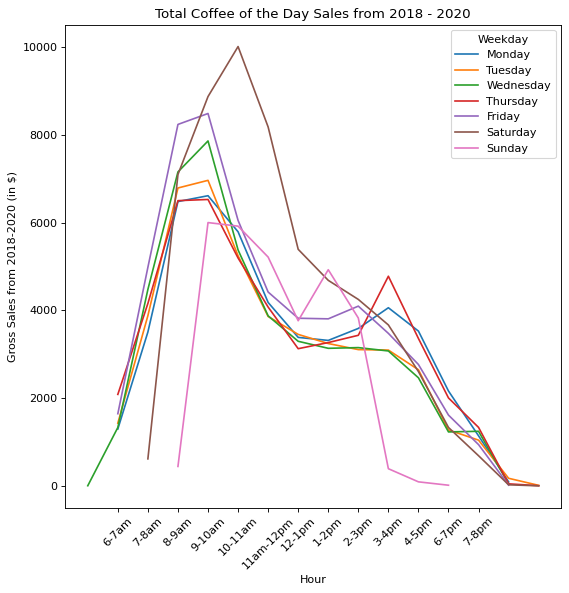

In [37]:
# plot a line graph of gross sales distribution by day to see in an easier format
figure(figsize=(8, 8), dpi=80)
line = pd.DataFrame(df.groupby(['Weekday','Hour'])['Gross Sales'].agg('sum')).reset_index()
ax = sns.lineplot(data=line, hue='Weekday', y='Gross Sales', x='Hour', hue_order=weekdays)
ax.set_xticks(range(6, 6+len(hours)))
ax.set_xticklabels(hours)
plt.xticks(rotation=45)
plt.ylabel('Gross Sales from 2018-2020 (in $)')
plt.title('Total Coffee of the Day Sales from 2018 - 2020')

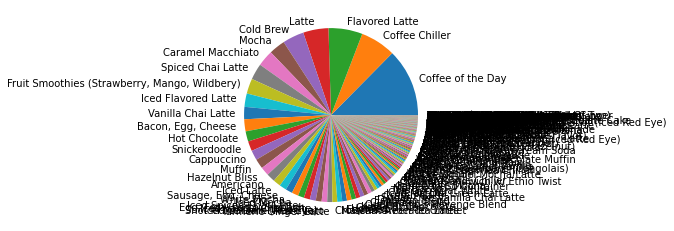

In [38]:
# plot the distribution throughout Saturday - is there something that can be taken advantage of?
sat = df[df['Weekday'] == 'Saturday']
sat2 = sat.groupby(['Item'])['Gross Sales'].sum().sort_values(ascending=False).reset_index()
plt.pie(labels=sat2['Item'], x=sat2['Gross Sales']);


## Saturday hourly distribution
This next section uses pie plots to visualize the change in distribution of Saturday's sales, although the function can be used more generally. It determines that the relative popularity of the coffee of the day in the morning gives way to the coffee chiller by evening.

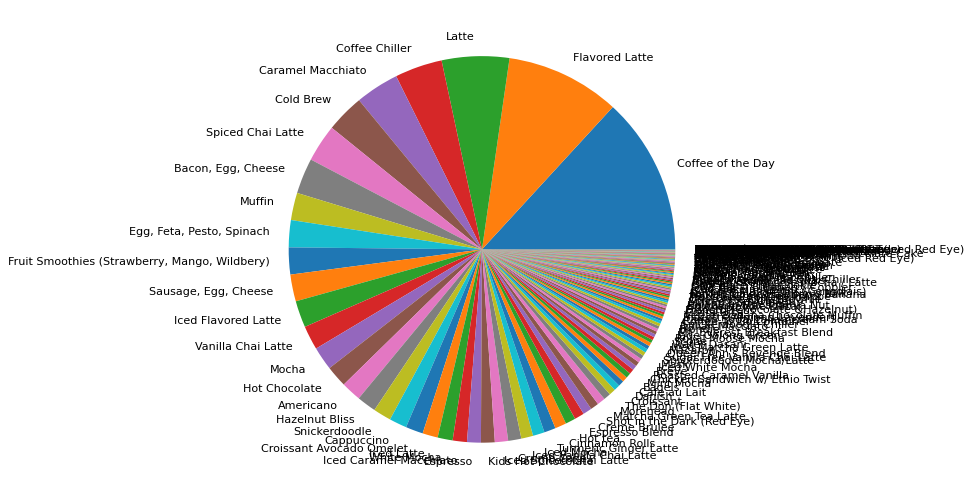

In [39]:
# create a plotting function to see an average distribution by day and hour
def plot_dist_hour_day(df, hour, day):
  figure(figsize=(10, 8), dpi=80)
  a = df[df['Weekday'] == day]
  b = a[a['Hour'] == hour].groupby('Item')['Gross Sales'].sum().sort_values(ascending=False).reset_index()
  plt.pie(labels=b['Item'], x=b['Gross Sales'])
  plt.show()

plot_dist_hour_day(df, 10, 'Saturday')

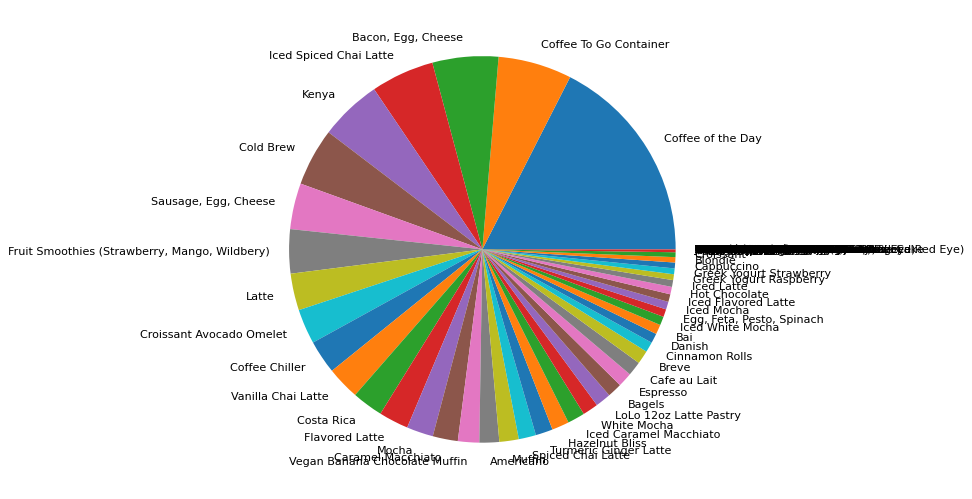

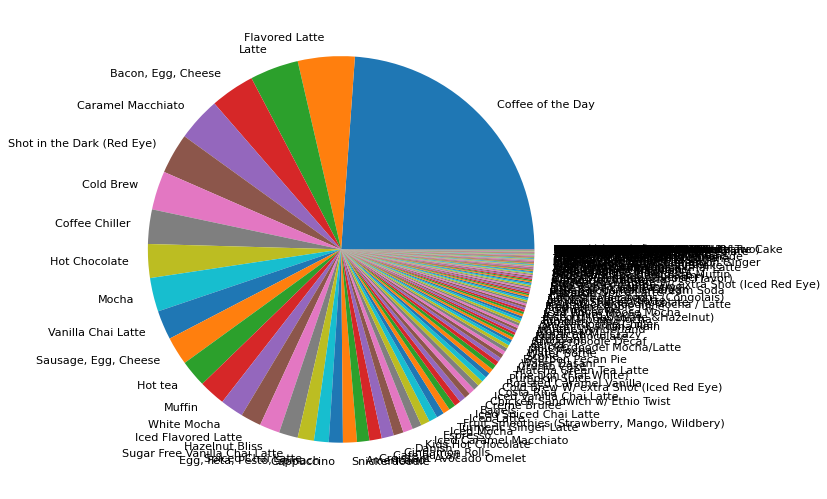

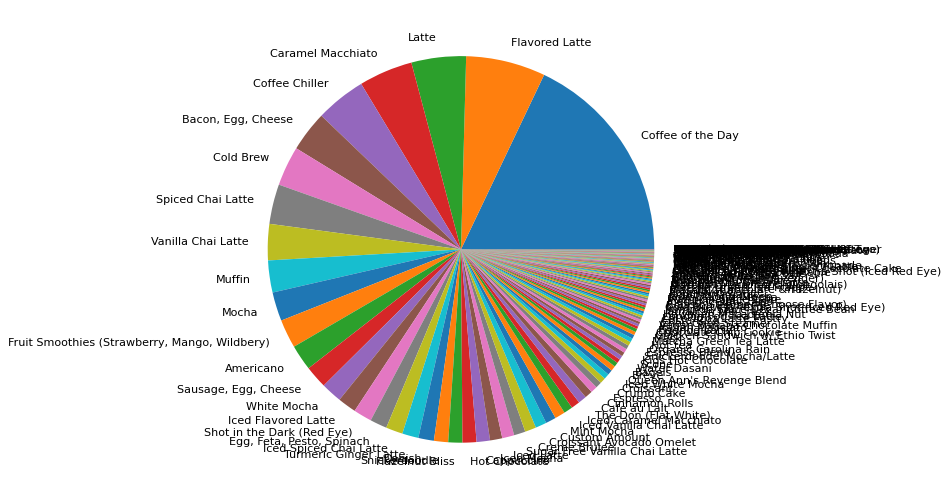

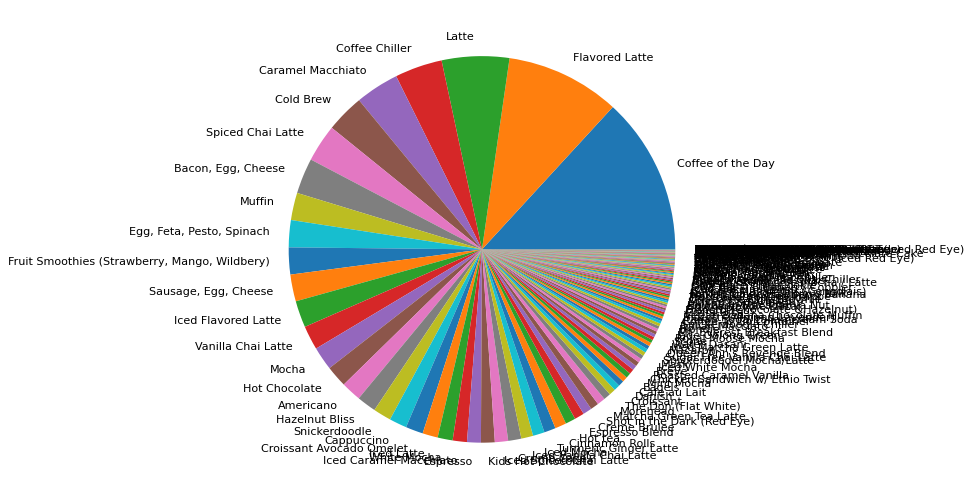

KeyboardInterrupt: ignored

In [40]:
# visualize different hours
plot_dist_hour_day(df, 7, 'Saturday')
plot_dist_hour_day(df, 8, 'Saturday')
plot_dist_hour_day(df, 9, 'Saturday')
plot_dist_hour_day(df, 10, 'Saturday')
plot_dist_hour_day(df, 11, 'Saturday')
plot_dist_hour_day(df, 12, 'Saturday')

In [ ]:
plot_dist_hour_day(df, 13, 'Saturday')
plot_dist_hour_day(df, 14, 'Saturday')

In [ ]:
plot_dist_hour_day(df, 15, 'Saturday')
plot_dist_hour_day(df, 16, 'Saturday')

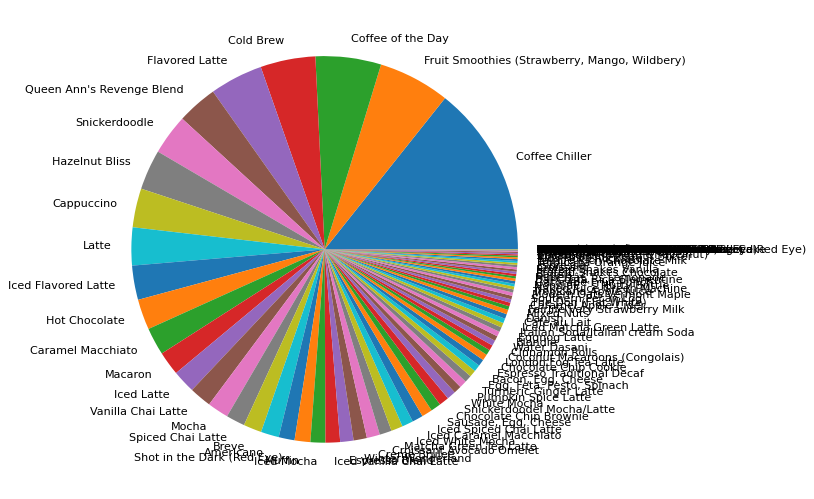

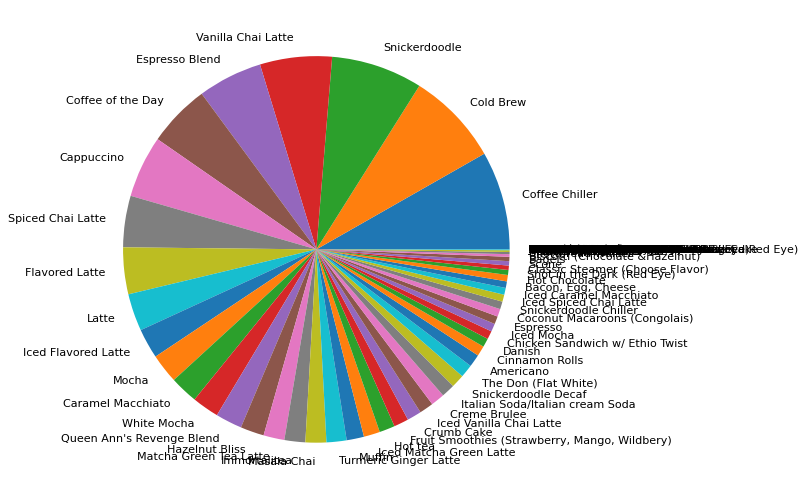

In [41]:
# as the day goes on, the main selling product shifts from coffee of the day to coffee chiller
plot_dist_hour_day(df, 17, 'Saturday')
plot_dist_hour_day(df, 18, 'Saturday')

## ROI Prototype
This next section is a prototype for calculating ROIs on products, and eventually product margins.

In [42]:
profit = df[df['Item'] == 'Espresso']['Gross Sales'].sum()
profit

3256.3

In [43]:
df[df['Item'] == 'Espresso']['Count'].sum()

1272

In [44]:
df[df['Item'] == 'Espresso']['Price Point Name'].value_counts()

doubleshot    829
quadshot      288
tripleshot     96
0.5lb           0
10oz            0
12oz            0
16oz            0
1lb             0
20oz            0
3oz             0
3pack           0
8oz             0
curved          0
regular         0
Name: Price Point Name, dtype: int64

In [45]:
# $0.35 per shot of espresso
shot = .35
total_cost = 829*shot*2 + 288*shot*4 + 96*shot*3 
total_cost

1084.3

In [46]:
roi_espresso = (profit-total_cost)/total_cost*100
roi_espresso

200.3135663561745

In [47]:
profit = df[df['Item'] == 'Coffee of the Day']['Gross Sales'].sum()
profit

45895.25000000001

In [48]:
df[df['Item'] == 'Coffee of the Day']['Price Point Name'].value_counts()

16oz          6427
20oz          6196
12oz          6137
0.5lb            0
10oz             0
1lb              0
3oz              0
3pack            0
8oz              0
curved           0
doubleshot       0
quadshot         0
regular          0
tripleshot       0
Name: Price Point Name, dtype: int64

In [49]:
# drip coffee, $3.96 per gallon, so estimate the same
# 128 fluid ounces in a gallon
small_price = 3.96/128*12
medium_price = 3.96/128*16
large_price = 3.96/128*20

In [50]:
total_cost = 6137*small_price + 6427*medium_price + 6196*large_price
total_cost

9293.50125

In [51]:
roi_coffee = (profit-total_cost)/total_cost*100
roi_coffee

393.8424041208367

## Calculating profit margins
This section finds the individual profit margins of the top 80% of products. According to the Pareto Principle, around 20% of products account for 80% of profits and revenue, and that is the pattern observed here. It is explored with the purpose of determining which products have a good cost margin balance and which are insufficient for the fixed operating costs of the coffee shop.

In [52]:
df2 = df

# create a function that takes a dataframe, product name, and then the prices for different price points
# it adds a column and accordingly updates a cost value to be in accordance with each transaction
# it accounts for the products needed such as cups and lids, and straws are added at random
def add_cost_drink(dataframe, product_name, small_price=1, medium_price=1, large_price=1):
  dataframe.loc[(dataframe['Item'] == product_name) & \
                (dataframe['Price Point Name'] == '12oz'), ['Cost']] = small_price
  dataframe.loc[(dataframe['Item'] == product_name) & \
                (dataframe['Price Point Name'] == '16oz'), ['Cost']] = medium_price
  dataframe.loc[(dataframe['Item'] == product_name) & \
                (dataframe['Price Point Name'] == '20oz'), ['Cost']] = large_price
  dataframe.loc[(dataframe['Item'] == product_name) & \
                (dataframe['Price Point Name'] == '12oz') & \
                (dataframe['Modifiers Applied'].str.contains("Milk Substitution")), ['Cost']] += 0.36
  dataframe.loc[(dataframe['Item'] == product_name) & \
                (dataframe['Price Point Name'] == '16oz') & \
                (dataframe['Modifiers Applied'].str.contains("Milk Substitution")), ['Cost']] += 0.43
  dataframe.loc[(dataframe['Item'] == product_name) & \
                (dataframe['Price Point Name'] == '20oz') & \
                (dataframe['Modifiers Applied'].str.contains("Milk Substitution")), ['Cost']] += 0.50
  dataframe.loc[(dataframe['Item'] == product_name) & \
                (dataframe['Modifiers Applied'].str.contains('Add Extra Espresso Shot')), ['Cost']] += 0.35
  dataframe.loc[(dataframe['Item'] == product_name) & \
                (dataframe['Modifiers Applied'].str.contains('Add Extra Flavor')), ['Cost']] += 6.81/25.3605 # assumed one ounce of extra flavor
  dataframe.loc[(dataframe['Item'] == product_name), ['Cost']] += 0.15 + 0.05 # adding cost of cup and lid
  dataframe.loc[(dataframe['Item'] == product_name), ['Cost']] += round(random.random(), 0)*0.03 # randomly add straw cost to some orders
  return dataframe

# a similar function is created using arrays for products like sandwiches and water bottles
def add_cost_product(dataframe, product_name, prices_list):
  dataframe.loc[(dataframe['Item'] == product_name), ['Cost']] = sum(prices_list)
  return dataframe

# the espresso takes a different structure due to the dominating cost being the number of shots of espresso
def add_cost_espresso(dataframe, product_name, regular=0.35, double=0.35*2, triple=0.35*3, quad=0.35*4):
  dataframe.loc[(dataframe['Item'] == product_name) & \
                (dataframe['Price Point Name'] == 'regular'), ['Cost']] = regular
  dataframe.loc[(dataframe['Item'] == product_name) & \
                (dataframe['Price Point Name'] == 'doubleshot'), ['Cost']] = double
  dataframe.loc[(dataframe['Item'] == product_name) & \
                (dataframe['Price Point Name'] == 'tripleshot'), ['Cost']] = triple
  dataframe.loc[(dataframe['Item'] == product_name) & \
                (dataframe['Price Point Name'] == 'quadshot'), ['Cost']] = quad
  dataframe.loc[(dataframe['Item'] == product_name), ['Cost']] += 0.15 + 0.05 # adding cost of cup and lid
  dataframe.loc[(dataframe['Item'] == product_name), ['Cost']] += round(random.random(), 0)*0.03 # randomly add straw cost to some orders
  return dataframe

In [53]:
# what are the number of purchases of each item?
df['Item'].value_counts()

Coffee of the Day    18760
Flavored Latte        5131
Coffee Chiller        4890
Cold Brew             4046
Latte                 3911
                     ...  
Walkers Choc Chip        1
Papua New Guinea         1
Tea Set                  1
Coconut Cream            1
Jam Strawberry           1
Name: Item, Length: 248, dtype: int64

In [54]:
# view modifiers applied
item = 'Coffee of the Day'
df[df['Item'] == item]['Modifiers Applied'].value_counts()

Add Extra Flavor                                     431
Add one pump                                         146
Add Extra Espresso Shot                               68
Milk Substitution                                     38
Chai Sweeten                                           9
                                                    ... 
Add Extra Flavor, Milk Substitution, Add one pump      0
Add Extra Flavor, Coconut                              0
Add Extra Flavor, Caramel                              0
Add Extra Flavor, Almond                               0
whole, skim                                            0
Name: Modifiers Applied, Length: 88, dtype: int64

In [55]:
df2 = df

# go through the list of most grossing revenue, and ~80% of product revenue comes from these top 39 products
df2 = add_cost_drink(df2, 'Coffee of the Day', 0.7529, 0.9188, 1.3149) # the coffee of the day is likely a different drink each day
                                                                                      # we assume that the price is on average the price of a flavored latte
                                                                                      # due to the number of flavored-latte-style drinks
df2 = add_cost_drink(df2, 'Flavored Latte', 0.7529, 0.9188, 1.3149)
df2 = add_cost_drink(df2, 'Coffee Chiller', 1, 1.25, 1.49)
df2 = add_cost_drink(df2, 'Cold Brew', 1, 6.96/128*16, 6.96/128*20)
df2 = add_cost_drink(df2, 'Latte', 0.5515, 0.6503, 0.9792)
df2 = add_cost_drink(df2, 'Mocha', 0.79, 1.00, 1.45)
df2 = add_cost_drink(df2, 'Spiced Chai Latte', 1.12, 1.22, 1.55)
df2 = add_cost_product(df2, 'Muffin', [1.12])
df2 = add_cost_drink(df2, 'Caramel Macchiato', 0.7529, 0.9188, 1.3149) # assumed the same as a flavored latte
df2 = add_cost_drink(df2, 'Americano', 0.7529, 0.9188, 1.3149) # assumed same as flavored latte
df2 = add_cost_drink(df2, 'Iced Flavored Latte', 0.7529, 0.9188, 1.3149)
df2 = add_cost_drink(df2, 'Fruit Smoothies (Strawberry, Mango, Wildbery)', 1, 1.15, 1.54)
df2 = add_cost_drink(df2, 'Cappuccino', 0.7529, 0.9188, 1.3149) # assumed same as flavored latte
df2 = add_cost_drink(df2, 'Hot Chocolate', 0.5515, 0.6503, 0.9792) # assumed roughly same price as latte due to ingredients similarity
df2 = add_cost_drink(df2, 'Hot tea', 3.96/128*12, 3.96/128*16, 3.96/128*20) # assume same price as coffee, around ~$0.37 for one cup of tea https://blog.teabox.com/much-good-tea-cost
df2 = add_cost_product(df2, 'Bacon, Egg, Cheese', [1.78, 0.25, 0.17])
df2 = add_cost_drink(df2, 'Hazelnut Bliss', 0.7529, 0.9188, 1.3149) # assume same as flavored latte
df2 = add_cost_espresso(df2, 'Espresso')
df2 = add_cost_drink(df2, 'Vanilla Chai Latte', 0.7529, 0.9188, 1.3149)
df2 = add_cost_product(df2, 'Sausage, Egg, Cheese', [0.31, 0.25, 0.17])
df2 = add_cost_drink(df2, 'White Mocha', 0.79, 1.00, 1.45)
df2 = add_cost_drink(df2, 'Shot in the Dark (Red Eye)', 3.96/128*12*(3/4)+0.35, 3.96/128*16*(3/4)+0.35, 3.96/128*20*(3/4)+0.35) # is a variant of drip coffee with an espresso shot, 3/4 of the drink is assumed to be drip coffee price
df2 = add_cost_drink(df2, 'Matcha Green Tea Latte', 1.12, 1.22, 1.55)
df2 = add_cost_product(df2, 'Egg, Feta, Pesto, Spinach', [0.25, 0.33, 0.32, 0.11])
df2 = add_cost_drink(df2, 'Iced Latte', 0.5515, 0.6503, 0.9792)
df2 = add_cost_drink(df2, 'Sugar Free Vanilla Chai Latte', 0.7529, 0.9188, 1.3149)
df2 = add_cost_drink(df2, 'Iced Mocha', 0.79, 1.00, 1.45)
df2 = add_cost_drink(df2, 'Iced Spiced Chai Latte', 1.12, 1.22, 1.55)
df2 = add_cost_drink(df2, 'Iced Caramel Macchiato', 0.7529, 0.9188, 1.3149)
df2 = add_cost_product(df2, 'Water Dasani', [5.39/24]) # price per bottle obtained from https://www.target.com/p/dasani-purified-water-24pk-16-9-fl-oz-bottles/-/A-14978383#lnk=sametab
df2 = add_cost_product(df2, 'Cinnamon Rolls', [1.47])
df2 = add_cost_drink(df2, 'Kids Hot Chocolate', 0.5515, 0.6503, 0.9792)
df2 = add_cost_product(df2, 'Creme Brulee', [1.12]) # cost assumed similar to Muffin
df2 = add_cost_drink(df2, 'Turmeric Ginger Latte', 0.7529, 0.9188, 1.3149)
df2 = add_cost_drink(df2, 'Iced Vanilla Chai Latte', 1.12, 1.22, 1.55)
df2 = add_cost_product(df2, 'Croissant Avocado Omelet', [0.41, 0.55, 0.62])
df2 = add_cost_product(df2, 'Danish', [0.99])
df2 = add_cost_drink(df2, 'The Don (Flat White)', 3.96/128*12+0.35, 3.96/128*16+0.35, 3.96/128*20+0.35) # contains drip coffee and espresso
df2 = add_cost_drink(df2, 'Cafe au Lait', 3.96/128*6+0.021*6, 3.96/128*8+0.021*8, 3.96/128*10+0.021*10) # assumed half milk, half drip coffee
df2 = add_cost_product(df2, 'Croissant', [0.41])


In [56]:
# focus on the 80% of items, 39 products
cost = df2[df2['Cost'].isna() == False]

In [57]:
# multiply the cost to make by the count of the item
cost['Cost'] *= cost['Count']

# profit margin needs to account for discounts, cost, and transaction cost (This will be a little off because it doesn't take into account the basketID)
cost['Profit Margin'] = cost['Gross Sales'] - cost['Discounts'] - cost['Cost'] - (cost['Gross Sales'] - cost['Discounts'])*0.025 - 0.10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [58]:
# use the median profit margin per transaction grouped by item
# median is chose as opposed to mean so as to avoid biasing the results toward large purchases of a product
cost[cost['Cost'].isna() == False].groupby(['Item'])[['Item', 'Gross Sales', 'Cost', 'Profit Margin']].agg('median').sort_values(ascending=False, by='Profit Margin').head(39)

,Gross Sales,Cost,Profit Margin
Item,,,
Coffee Chiller,4.55,1.480000,3.046250
Iced Caramel Macchiato,4.30,1.148800,2.943700
Turmeric Ginger Latte,4.25,1.332900,2.935850
Creme Brulee,4.15,1.120000,2.923750
The Don (Flat White),3.70,0.951250,2.897500
Caramel Macchiato,4.15,1.118800,2.856850
Hazelnut Bliss,4.15,1.148800,2.840100
"Sausage, Egg, Cheese",3.75,0.730000,2.826250
Iced Flavored Latte,4.25,1.118800,2.787450


In [59]:
# a quick check as to the sums of profit over the total data span
cost['Profit Margin'].sum()

171087.383091679

In [60]:
# view the cost dataframe
# this will be used for graphing profit margins
cost

,TimeStamp,BasketID,Category,Item,Price Point Name,SKU,Modifiers Applied,Gross Sales,Discounts,Count,...,CustomerID,UnitPrice,Date,Weekday,Year,Month,Month-Year,Hour,Cost,Profit Margin
0,2018-10-05 13:09:39,57034,From the Barista,Vanilla Chai Latte,12oz,NaN,NaN,3.50,0.00,1,...,5477,3.50,2018-10-05,Friday,2018,10,October-2018,13,0.9529,2.35960
1,2018-10-05 13:09:39,57034,From the Barista,Flavored Latte,20oz,NaN,NaN,4.45,-0.44,1,...,5477,4.45,2018-10-05,Friday,2018,10,October-2018,13,1.5149,3.15285
2,2018-10-05 13:15:00,52838,What's Brewing,Coffee of the Day,16oz,NaN,NaN,2.25,0.00,1,...,-1,2.25,2018-10-05,Friday,2018,10,October-2018,13,1.1488,0.94495
3,2018-10-05 13:20:11,17649,From the Barista,Latte,20oz,NaN,NaN,3.95,0.00,1,...,-1,3.95,2018-10-05,Friday,2018,10,October-2018,13,1.1792,2.57205
5,2018-10-05 14:17:05,37960,From the Barista,Flavored Latte,16oz,NaN,NaN,4.00,0.00,1,...,2196,4.00,2018-10-05,Friday,2018,10,October-2018,14,1.1188,2.68120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91875,2020-10-05 10:00:35,59507,Cool Drink,Cold Brew,20oz,NaN,NaN,7.10,-0.57,2,...,7112,3.55,2020-10-05,Monday,2020,10,October-2020,10,2.6350,4.74325
91876,2020-10-05 10:04:24,16245,From the Barista,Flavored Latte,20oz,NaN,"Add Extra Espresso Shot, whole",5.35,-0.92,1,...,9676,5.35,2020-10-05,Monday,2020,10,October-2020,10,1.8649,4.14835
91877,2020-10-05 10:04:24,16245,From the Barista,Hazelnut Bliss,20oz,NaN,NaN,4.90,-0.84,1,...,9676,4.90,2020-10-05,Monday,2020,10,October-2020,10,1.5449,3.95160
91878,2020-10-05 09:52:10,58753,From the Barista,Vanilla Chai Latte,16oz,NaN,whole,4.30,-0.35,1,...,699,4.30,2020-10-05,Monday,2020,10,October-2020,9,1.1188,3.31495


In [61]:
# what is the mean number of transaction lines per month
df.groupby(['Month-Year']).size().agg('mean')

3670.96

In [62]:
# Costs per month
rent = 2400

electric, gas, internetPhone, security = 300, 50, 125, 50
utilities = electric + gas + internetPhone + security

businessInsur, employeeInsur = 116.67, 40 
insurance = businessInsur + employeeInsur

licensing = 200
maintenance = 116.67
promotions = 35
software = 35

avg_hourly_pay = 8.25
shift_hours_per_week = 73.5
num_weeks_per_month = 4.345 # according to Google
num_employees_per_hour = 2
total_employee_hours = num_employees_per_hour * shift_hours_per_week * num_weeks_per_month
total_employee_cost = avg_hourly_pay * total_employee_hours

total_monthly_fixed_cost = rent + utilities + insurance + licensing + maintenance + promotions + software + total_employee_cost
print(total_monthly_fixed_cost)

8737.73875


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

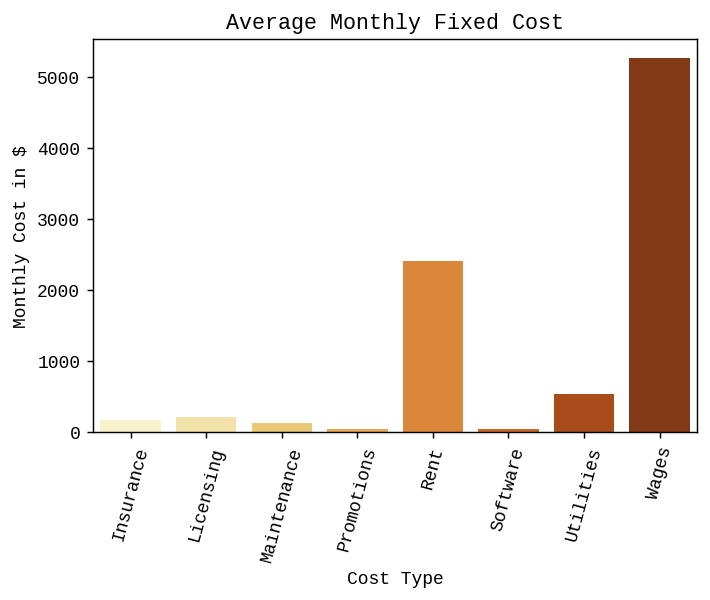

In [63]:
# graph a bar plot of costs
rcParams['font.family'] = 'Liberation Mono'
figure(figsize=(6, 4), dpi=130)
cost_values = [rent, utilities, insurance, licensing, maintenance, promotions, software, total_employee_cost]
# plt.bar(x=1, height=cost_values)
costs = np.array([['Rent', rent],
                  ['Utilities', utilities],
                  ['Insurance', insurance],
                  ['Licensing', licensing],
                  ['Maintenance', maintenance],
                  ['Promotions', promotions],
                  ['Software', software],
                  ['Wages', total_employee_cost]])
cost_values_df = pd.DataFrame(costs, columns=['Name', 'Amount'])
cost_values_df['Name'] = cost_values_df['Name'].astype('category')
cost_values_df['Amount'] = cost_values_df['Amount'].astype('float')
g = sns.barplot(data=cost_values_df, x='Name', y='Amount', palette='YlOrBr')
plt.xticks(rotation=75)
plt.title('Average Monthly Fixed Cost')
plt.ylabel('Monthly Cost in $')
plt.xlabel('Cost Type')

plt.savefig('fixedcosts.png', bbox_inches="tight", transparent=True)
files.download('fixedcosts.png')

In [64]:
# View the profit margins over 2019
year = 2019
year_profit = cost[cost['Year'] == year].groupby(['Month']).agg('sum')['Profit Margin']
year_profit = pd.DataFrame(year_profit)
year_profit = year_profit.reset_index()
year_profit

,Month,Profit Margin
0,1,7736.221442
1,2,7046.611828
2,3,8191.089867
3,4,7087.399253
4,5,7485.339181
5,6,7241.150768
6,7,7071.411090
7,8,7541.076429
8,9,7179.643388
9,10,7995.086194


In [65]:
cost['Profit Margin'].median()

2.3596

In [66]:
# how many unique items are there?
print(df['Item'].nunique())
print(39/df['Item'].nunique())

248
0.15725806451612903


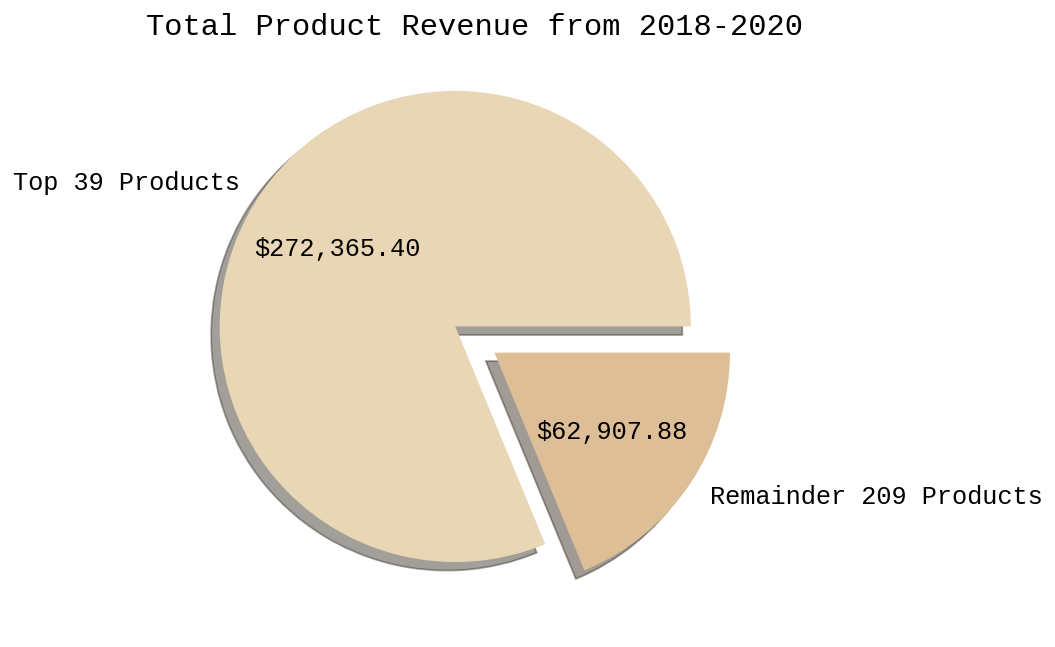

In [67]:
# 15% of the menu is responsible for ~80% of Gross Sales

# import  matplotlib.font_manager
# flist = matplotlib.font_manager.get_fontconfig_fonts()
# names = [matplotlib.font_manager.FontProperties(fname=fname).get_name() for fname in flist]
# print(names)

rcParams['font.family'] = 'Liberation Mono'
figure(figsize=(10, 6), dpi=130)
total_rev = df['Gross Sales'].sum()
rev_top_39 = cost['Gross Sales'].sum()
rev_remainder = total_rev - rev_top_39
values = [rev_top_39, rev_remainder]
labels = ['Top 39 Products', 'Remainder 209 Products']
plt.rcParams.update({'font.size': 14})
fig = plt.pie(values, autopct=lambda x: '${:,.2f}'.format(x*np.sum(values)/100), explode=[0.1, 0.1], labels=labels, shadow=True, colors=['#e8d6b5', '#debe97'])
plt.title('Total Product Revenue from 2018-2020')

plt.savefig('dist.png', transparent=True)
# files.download('dist.png')

Text(0.5, 1.0, 'Total Product Revenue from 2018-2020')

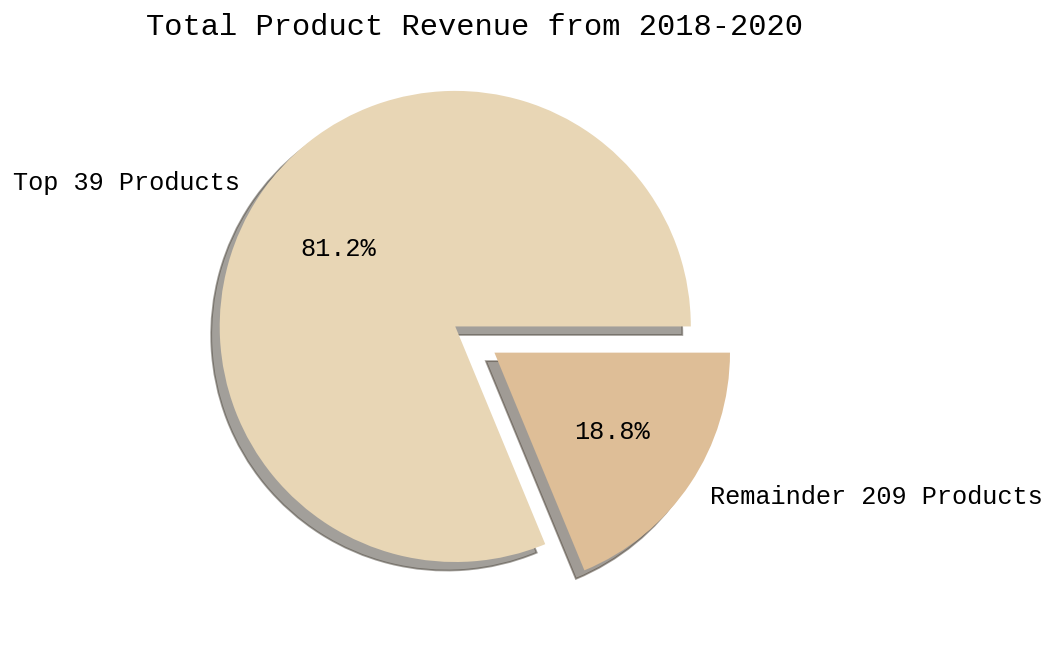

In [68]:
# same graph as above, but with percentages
rcParams['font.family'] = 'Liberation Mono'
figure(figsize=(10, 6), dpi=130)
total_rev = df['Gross Sales'].sum()
rev_top_39 = cost['Gross Sales'].sum()
rev_remainder = total_rev - rev_top_39
values = [rev_top_39, rev_remainder]
labels = ['Top 39 Products', 'Remainder 209 Products']
plt.rcParams.update({'font.size': 14})
fig = plt.pie(values, autopct='%0.1f%%', explode=[0.1, 0.1], labels=labels, shadow=True, colors=['#e8d6b5', '#debe97'])
plt.title('Total Product Revenue from 2018-2020')

Text(0.5, 1.0, 'Profit Margin by Month in 2019')

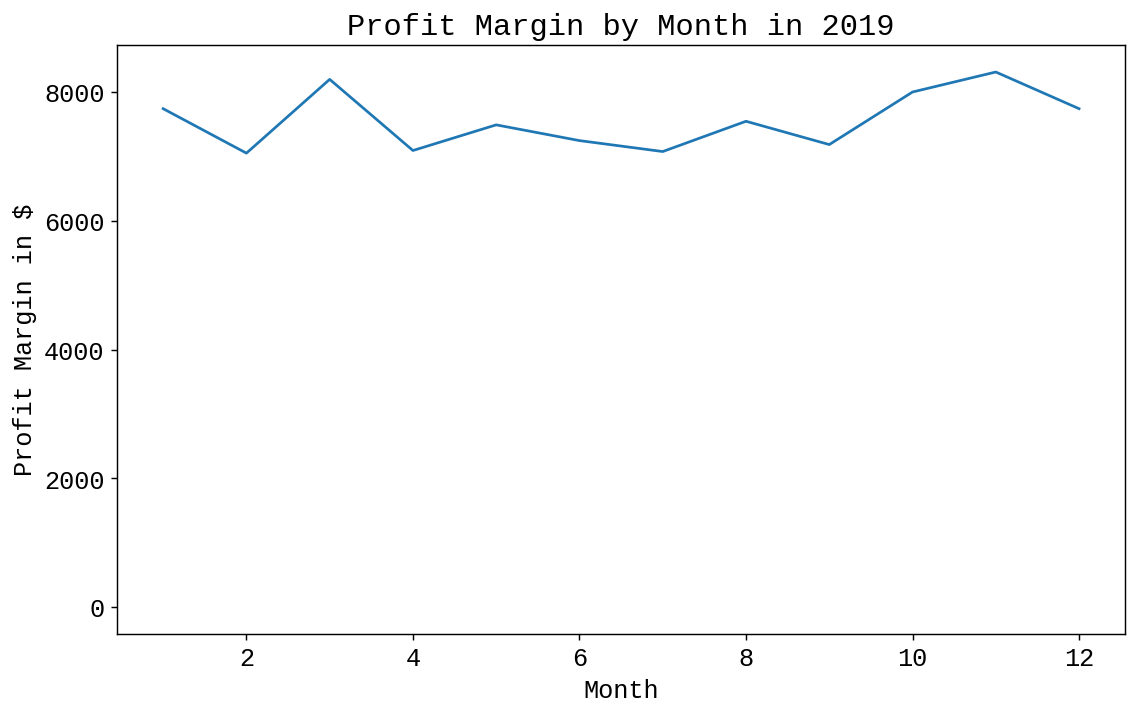

In [69]:
# view the profit margin by month in 2019
figure(figsize=(10, 6), dpi=130)  
plt.plot(year_profit['Month'], year_profit['Profit Margin'])
plt.plot(1, 0)
plt.xlabel('Month')
plt.ylabel('Profit Margin in $')
plt.title('Profit Margin by Month in ' + str(year))

In [70]:
# create a dataframe of the top 20 products
top_20 = pd.DataFrame(df['Item'].value_counts().head(20).reset_index())
print(top_20)

                                            index   Item
0                               Coffee of the Day  18760
1                                  Flavored Latte   5131
2                                  Coffee Chiller   4890
3                                       Cold Brew   4046
4                                           Latte   3911
5                                           Mocha   2384
6                               Spiced Chai Latte   2383
7                                          Muffin   2147
8                               Caramel Macchiato   1867
9                                       Americano   1837
10                            Iced Flavored Latte   1750
11  Fruit Smoothies (Strawberry, Mango, Wildbery)   1748
12                                     Cappuccino   1718
13                                  Hot Chocolate   1652
14                                        Hot tea   1624
15                             Bacon, Egg, Cheese   1623
16                             

In [71]:
# create a dataframe that gets the median profit margin by product
med_profit_margin = cost[cost['Cost'].isna() == False].groupby(['Item'])[['Item', 'Gross Sales', 'Cost', 'Profit Margin']].agg('median').sort_values(ascending=False, by='Profit Margin').head(39).reset_index()

Text(0.5, 1.0, 'Median Profit Margins of Top 39 Selling Products')

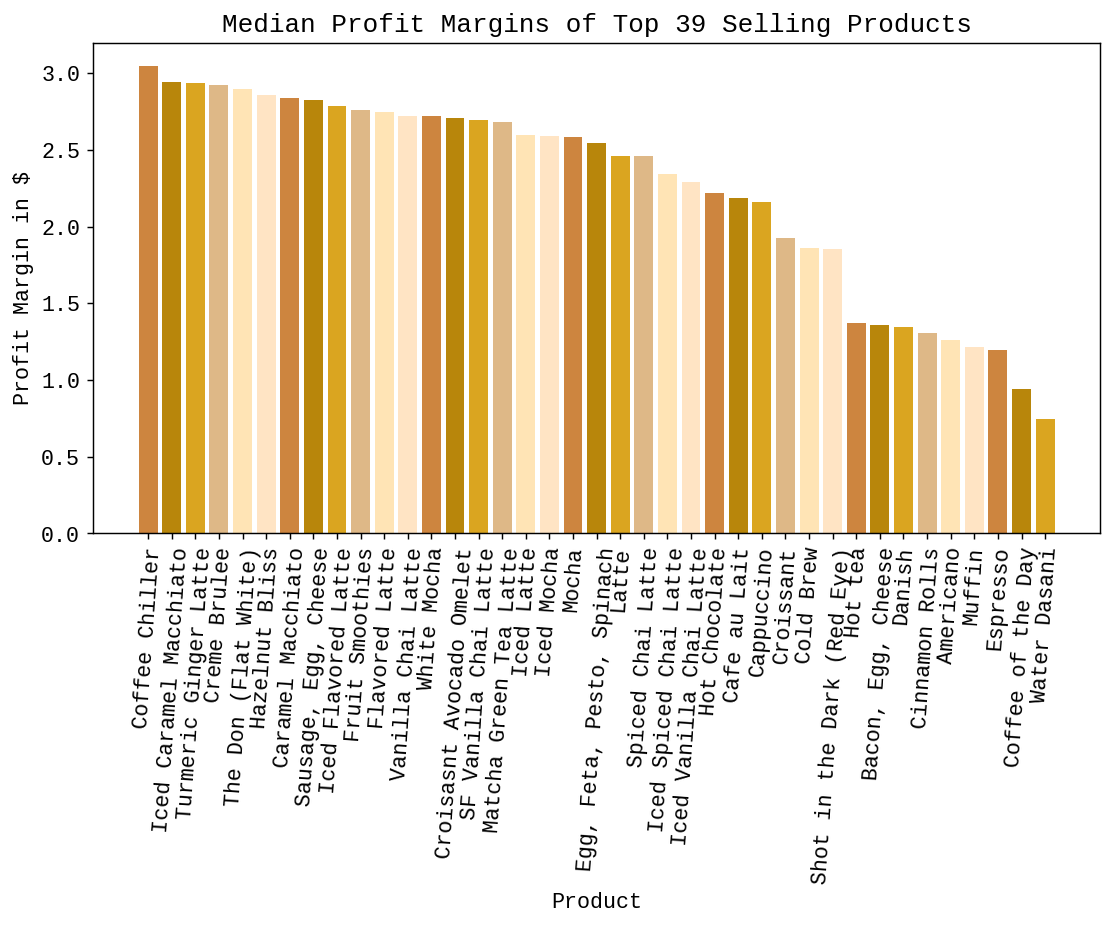

In [72]:
# create a bar graph of those profit margins
figure(figsize=(10, 5), dpi=130)
plt.rcParams.update({'font.size': 12})
colors = ['peru','darkgoldenrod','goldenrod','burlywood' ,'moccasin', 'bisque']
x = plt.bar(data=med_profit_margin, height='Profit Margin', x='Item', color=colors)
plt.xticks(range(39), 
           ('Coffee Chiller', 'Iced Caramel Macchiato', 'Turmeric Ginger Latte',
            'Creme Brulee', 'The Don (Flat White)', 'Hazelnut Bliss',
            'Caramel Macchiato', 'Sausage, Egg, Cheese', 'Iced Flavored Latte',
            'Fruit Smoothies', 'Flavored Latte', 'Vanilla Chai Latte', 'White Mocha',
            'Croisasnt Avocado Omelet', 'SF Vanilla Chai Latte', 'Matcha Green Tea Latte',
            'Iced Latte', 'Iced Mocha', 'Mocha', 'Egg, Feta, Pesto, Spinach', 'Latte',
            'Spiced Chai Latte', 'Iced Spiced Chai Latte', 'Iced Vanilla Chai Latte', 
            'Hot Chocolate', 'Cafe au Lait', 'Cappuccino', 'Croissant', 'Cold Brew', 
            'Shot in the Dark (Red Eye)', 'Hot tea', 'Bacon, Egg, Cheese', 'Danish',
            'Cinnamon Rolls', 'Americano', 'Muffin', 'Espresso', 'Coffee of the Day',
            'Water Dasani'))
plt.xticks(rotation = 86)
plt.xlabel('Product')
plt.ylabel('Profit Margin in $')
plt.title('Median Profit Margins of Top 39 Selling Products')

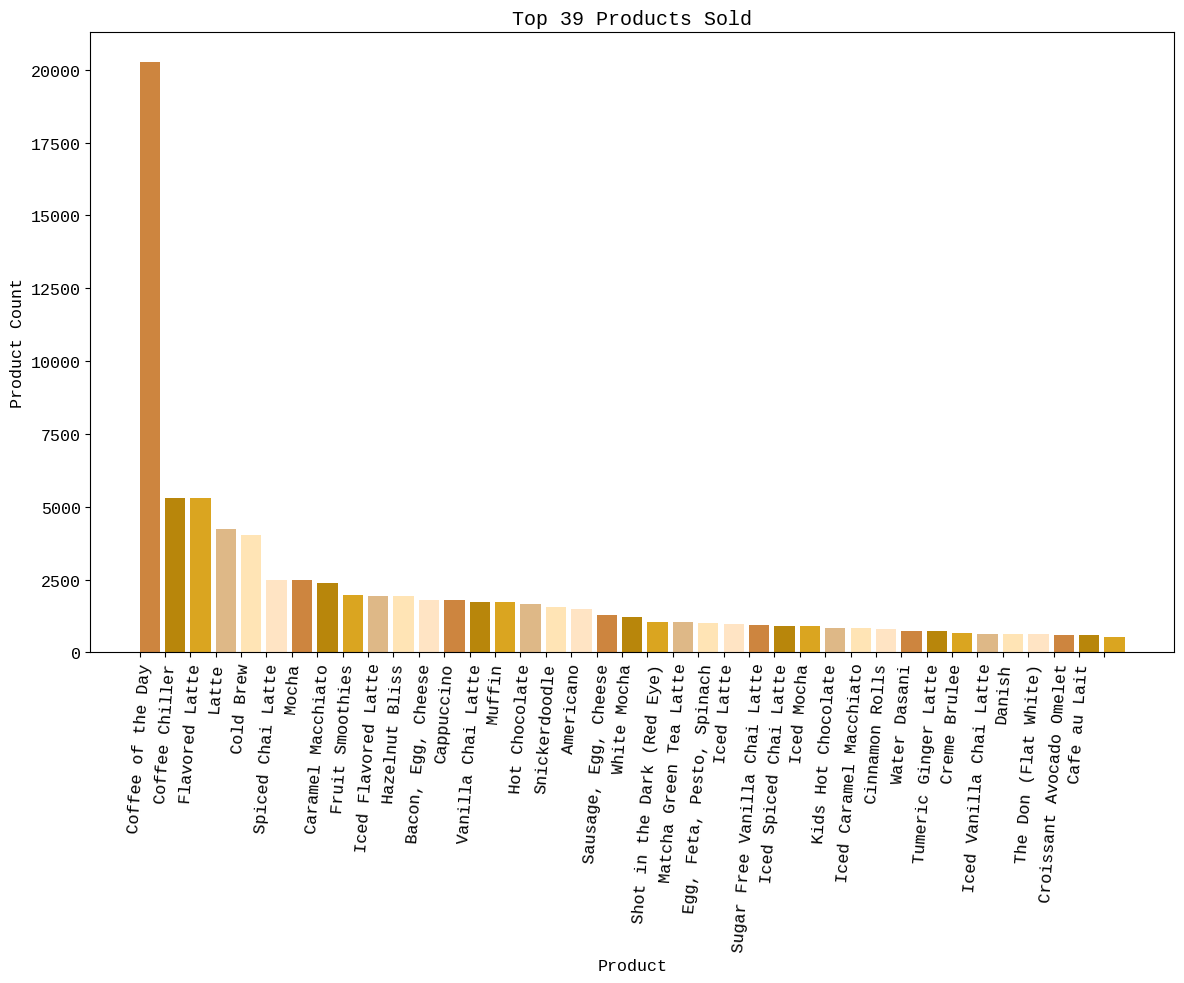

In [73]:
# view the counts of the top 39 sold products
first80profit = df.groupby(['Item'])['Count'].sum().sort_values(ascending=False).head(39).reset_index()

figure(figsize=(12, 10), dpi=100)
 
colors = ['peru','darkgoldenrod','goldenrod','burlywood' ,'moccasin', 'bisque']
plt.bar(x = first80profit.index, height = first80profit['Count'], width = .8, color = colors, align = 'edge', data = first80profit)
plt.xlabel('Product')
plt.xticks([i for i in range(39)], ('Coffee of the Day', 'Coffee Chiller', 'Flavored Latte',
                                                                 'Latte', 'Cold Brew', 'Spiced Chai Latte', 'Mocha', 'Caramel Macchiato',
                                                                 'Fruit Smoothies', 'Iced Flavored Latte', 'Hazelnut Bliss', 'Bacon, Egg, Cheese',
                                                                'Cappuccino', 'Vanilla Chai Latte', 'Muffin', 'Hot Chocolate','Snickerdoodle',
                                                                'Americano', 'Sausage, Egg, Cheese', 'White Mocha', 'Shot in the Dark (Red Eye)',
                                    'Matcha Green Tea Latte', 'Egg, Feta, Pesto, Spinach', 'Iced Latte', 'Sugar Free Vanilla Chai Latte', 'Iced Spiced Chai Latte', 'Iced Mocha',
                                    'Kids Hot Chocolate','Iced Caramel Macchiato', 'Cinnamon Rolls','Water Dasani','Tumeric Ginger Latte','Creme Brulee','Iced Vanilla Chai Latte','Danish',
                                    'The Don (Flat White)', 'Croissant Avocado Omelet', 'Cafe au Lait'))
plt.xticks(rotation = 86)
plt.ylabel('Product Count')
plt.title('Top 39 Products Sold')
plt.tight_layout()
plt.show()

In [74]:
# what is the average number of product purchase transaction lines?
checkouts_per_month = df.groupby(['Month-Year']).size().agg('mean')
checkouts_per_month 

3670.96

In [75]:
# what is the break-even point of an individual product, assuming average product sales per the month?
total_monthly_fixed_cost/checkouts_per_month

2.3802326230740736

## Working Hours Savings
Since the store isn't busy and doesn't make a lot of profit during some hours, we decided it wouldn't be profitable to open the store and have workers working during these hours. Below is how we found the hours to close.

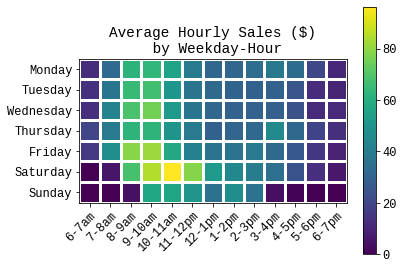

Hour              6          7          8          9          10         11  \
Weekday                                                                       
Monday     12.475865  33.714519  62.281058  63.562308  55.662885  40.185192   
Tuesday    13.757692  37.294423  65.253750  66.926058  50.402981  37.119135   
Wednesday  12.806442  43.040481  68.768750  75.552788  51.682115  37.250385   
Thursday   20.054808  39.968462  62.480192  62.738654  49.915096  39.173462   
Friday     15.822115  47.885865  79.171635  81.564904  58.154423  42.468654   
Saturday    0.000000   5.933654  68.208654  85.271538  96.222404  78.616346   
Sunday      0.000000   0.000000   4.277596  57.677115  56.894712  50.124423   

Hour              12         13         14         15         16         17  \
Weekday                                                                       
Monday     32.535481  31.873462  34.497788  39.028654  33.915769  20.788077   
Tuesday    33.189231  31.190769  29.861346  29.7576

Hour,6,7,8,9,10,11,12,13,14,15,16,17,18
Weekday,,,,,,,,,,,,,
Monday,12.475865,33.714519,62.281058,63.562308,55.662885,40.185192,32.535481,31.873462,34.497788,39.028654,33.915769,20.788077,10.978750
Tuesday,13.757692,37.294423,65.253750,66.926058,50.402981,37.119135,33.189231,31.190769,29.861346,29.757692,25.450096,12.272788,10.035385
Wednesday,12.806442,43.040481,68.768750,75.552788,51.682115,37.250385,31.680577,30.145673,30.299423,29.562692,23.689231,11.835865,11.971923
Thursday,20.054808,39.968462,62.480192,62.738654,49.915096,39.173462,30.061154,31.402885,32.994038,45.927692,32.293750,19.271154,12.824231
Friday,15.822115,47.885865,79.171635,81.564904,58.154423,42.468654,36.728846,36.598269,39.379423,33.417115,26.601538,15.517404,9.054904
Saturday,0.000000,5.933654,68.208654,85.271538,96.222404,78.616346,51.822212,45.029808,40.852019,35.261635,25.052212,12.809615,6.620192
Sunday,0.000000,0.000000,4.277596,57.677115,56.894712,50.124423,36.184135,47.357788,36.776442,3.778750,0.902404,0.162981,0.000000


In [76]:
#Create a 2D array of total profit for each weekday-hour combination (Reused and revamped from class 18 colab)
heatmap_df = df.groupby(['Weekday','Hour'])['Gross Sales'].agg('sum').unstack().fillna(0).reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
heatmap_df / 104
#Dropping hours with very low sales (typically closed)
heatmap_df.drop(columns = [5,19,20], inplace=True)
heatmap_array = np.array(heatmap_df)
 
# Create an array for the hours of operation and for the weekdays to be used as labels for the heatmap
hours = ["6-7am", "7-8am", "8-9am", "9-10am", "10-11am", "11-12pm", "12-1pm", "1-2pm", "2-3pm", "3-4pm", "4-5pm", "5-6pm","6-7pm"]
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
def heatmap(data, row_labels, col_labels, ax=None,
           cbar_kw={}, cbarlabel="", **kwargs): 
   if not ax:
       ax = plt.gca()
 
   # Plot the heatmap
   im = ax.imshow(data, **kwargs)
 
   # Create colorbar
   cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
   cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
 
   # Show all ticks
   ax.set_xticks(np.arange(data.shape[1]))
   ax.set_yticks(np.arange(data.shape[0]))
   # Label ticks with the respective list entries
   ax.set_xticklabels(col_labels)
   ax.set_yticklabels(row_labels)
 
   # Rotate the tick labels and set their alignment
   plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
 
   ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
   ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
   ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
   ax.tick_params(which="minor", bottom=False, left=False)
 
   return im, cbar

fig, ax = plt.subplots()
im, cbar = heatmap(heatmap_array / 104, weekdays, hours, ax=ax)
ax.set_title("Average Hourly Sales ($)\n by Weekday-Hour")
fig.tight_layout()
plt.show()

print(heatmap_df / 104)
heatmap_df = heatmap_df / 104
heatmap_df.style.background_gradient()
# Divided by 104 for weeks

In [77]:
# number of hours reduced per week
num_hours_reduced = 0.5*5 + 2*6
price_per_hour = 8.25*2
num_weeks_per_year = 52

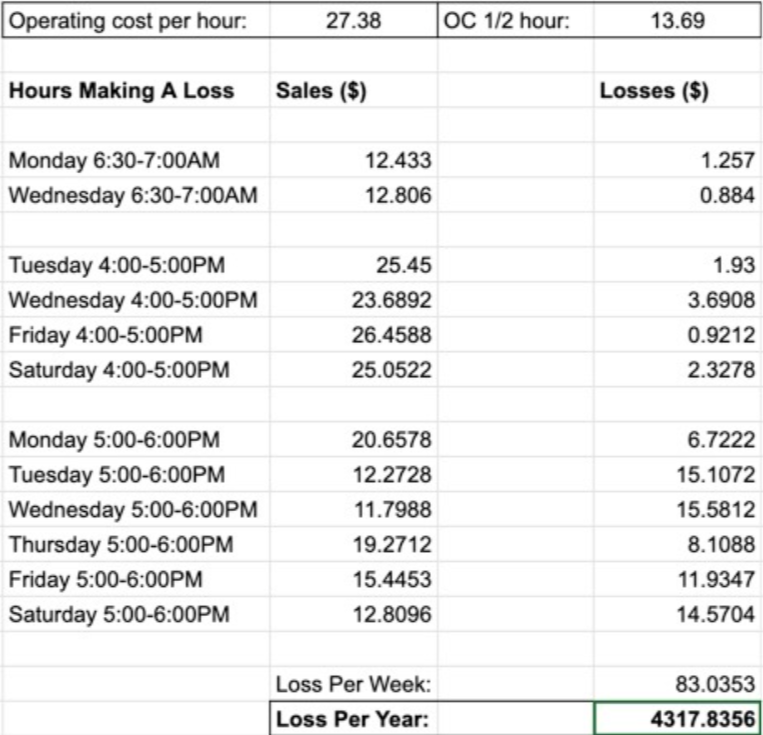

## Conclusion
Our analysis reveals that the menu is bloated - a huge percentage of gross revenue relies on around a fifth of the current available products. Fewer items means less training time for employees and potential turnover, which implies greater efficiency in creating drinks and higher drink quality if the baristas can specialize on a smaller, select set. Next, the inventory (not provided) should be adjusted accordingly such that the required materials are satisfied with some extra to account for potential surges (https://smallbusiness.chron.com/manage-inventory-products-reach-decline-stage-12299.html). They should be ordered frequently and as needed. Inventory loss, especially perishable products like dairy, can incur a large cost. 
 
The coffee shop’s open hours should be adjusted to 7AM-4PM on weekdays, 7AM-4PM on Saturday, and kept at 8AM-1PM on Sunday. This has savings of around $4,318 per year.
